In [61]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from astropy.cosmology import default_cosmology
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import lenstronomy_sim, survey_sim, gs

In [74]:
pickle_path = os.path.join(config.machine.dir_00, 'detectable_gglenses_0000_sca01.pkl')  # detectable_gglenses_01
detectable_gglenses = util.unpickle(pickle_path)

print(f'{len(detectable_gglenses)} detectable lens(es)')

28 detectable lens(es)


In [75]:
band = 'F129'

sample_gglens = np.random.choice(detectable_gglenses)
# sample_gglens = detectable_gglenses[0]
sample_lens = lens_util.slsim_lens_to_mejiro(sample_gglens, bands=[band], cosmo=default_cosmology.get())

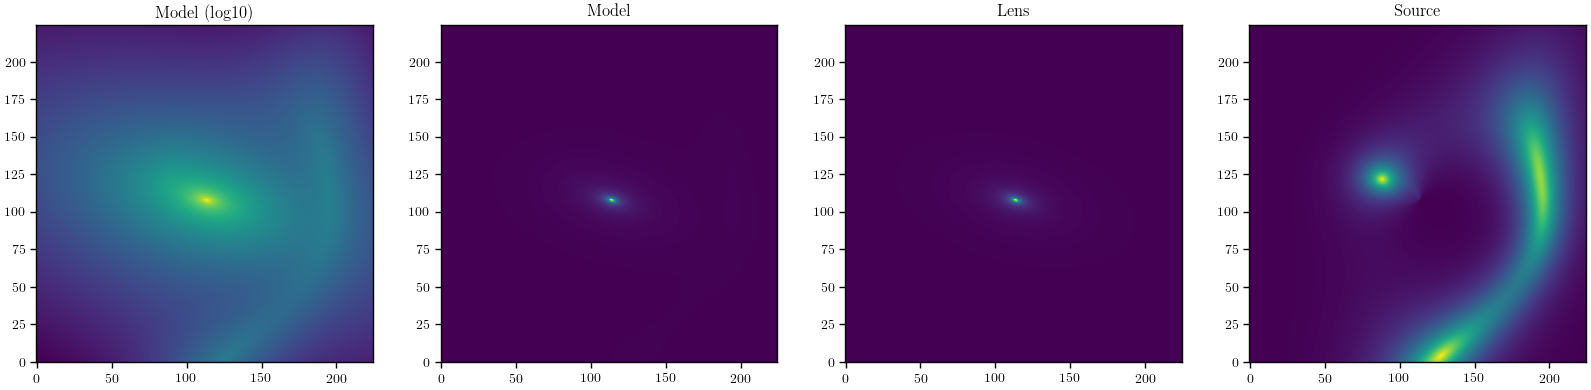

In [102]:
model, lens_sb, source_sb = sample_lens.get_array(45 * 5, 4.95, band, return_pieces=True)

f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(np.log10(model))
ax[0].set_title('Model (log10)')
ax[1].imshow(model)
ax[1].set_title('Model')
ax[2].imshow(lens_sb)
ax[2].set_title('Lens')
ax[3].imshow(source_sb)
ax[3].set_title('Source')
plt.show()

Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_5.pkl


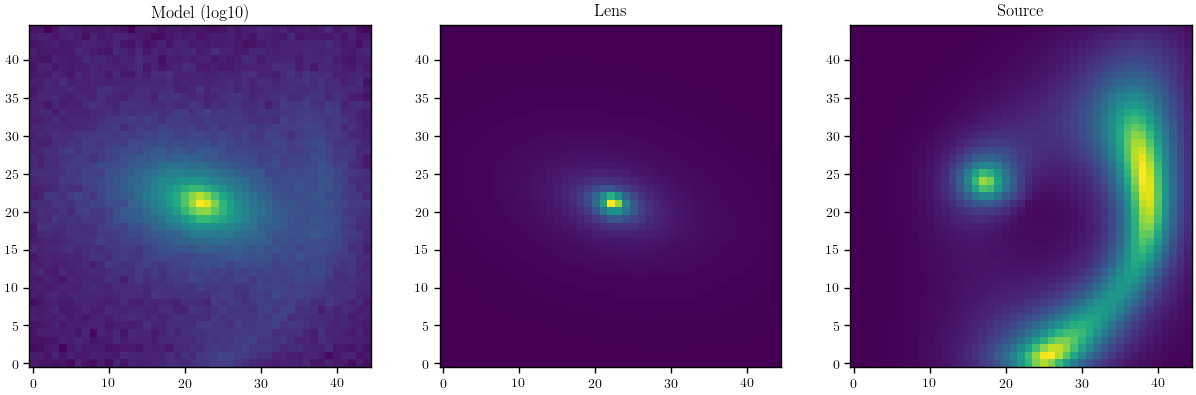

In [103]:
results, lenses, sources, execution_time = gs.get_images(sample_lens, [model], [band], 45, 45, 5, 5,
               lens_surface_brightness=[lens_sb], source_surface_brightness=[source_sb], detector=1, detector_pos=(2048, 2048),
               exposure_time=146, ra=30, dec=-30, seed=42, validate=False, suppress_output=False, check_cache=True)

f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(results[0]))
ax[0].set_title('Model (log10)')
ax[1].imshow(lenses[0])
ax[1].set_title('Lens')
ax[2].imshow(sources[0])
ax[2].set_title('Source')
plt.show()

In [104]:
# put back into units of counts
total = results[0] * 146
lens = lenses[0] * 146
source = sources[0] * 146

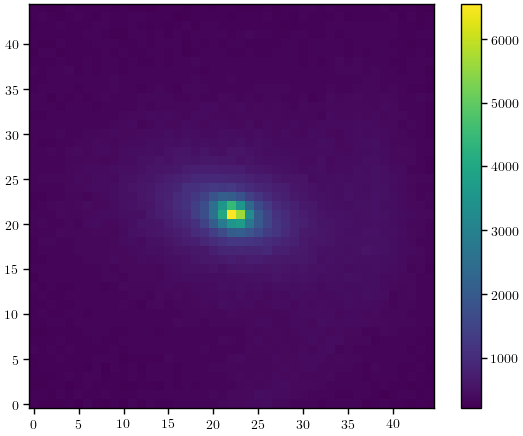

In [105]:
plt.imshow(total)
plt.colorbar()
plt.show()

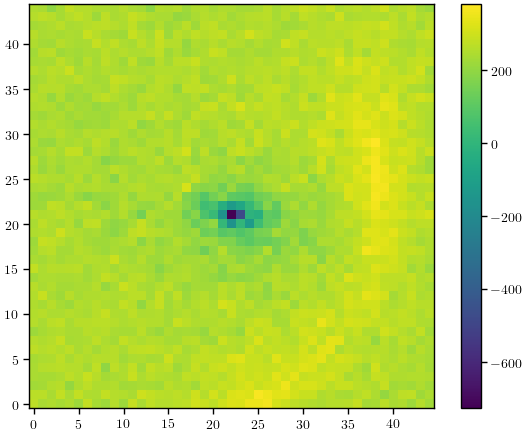

In [106]:
noise = total - (lens + source)

plt.imshow(noise)
plt.colorbar()
plt.show()

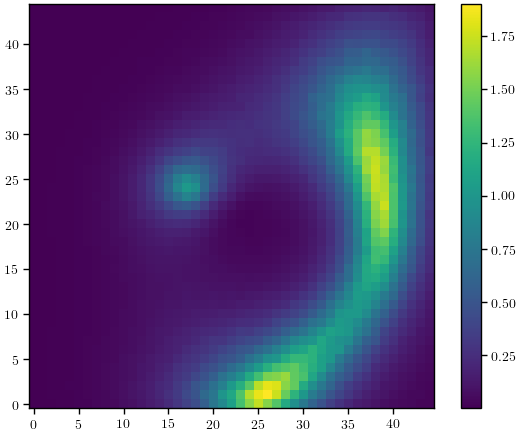

In [107]:
snr_array = source / np.sqrt(total)

plt.imshow(snr_array)
plt.colorbar()
plt.show()

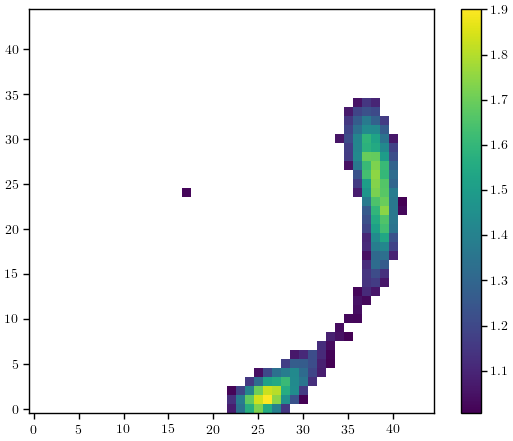

In [108]:
regions = np.ma.masked_where(snr_array <= 1, snr_array)

plt.imshow(regions)
plt.colorbar()
plt.show()

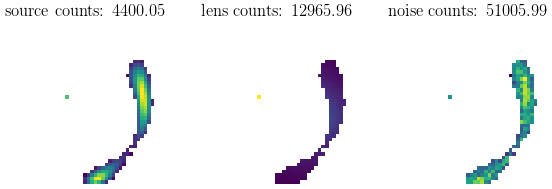

In [109]:
# mask source
masked_source = np.ma.masked_where(snr_array <= 1, source)
source_counts = masked_source.compressed().sum()

# mask lens
masked_lens = np.ma.masked_where(snr_array <= 1, lens)
lens_counts = masked_lens.compressed().sum()

# mask noise
masked_noise = np.ma.masked_where(snr_array <= 1, noise)
noise_counts = masked_noise.compressed().sum()

f, ax = plt.subplots(1, 3)
ax[0].imshow(masked_source)
ax[0].set_title(f'source counts: {source_counts:.2f}')
ax[0].axis('off')
ax[1].imshow(masked_lens)
ax[1].set_title(f'lens counts: {lens_counts:.2f}')
ax[1].axis('off')
ax[2].imshow(masked_noise)
ax[2].set_title(f'noise counts: {noise_counts:.2f}')
ax[2].axis('off')
plt.show()

In [110]:
# calculate estimated SNR
snr = source_counts / np.sqrt(source_counts + lens_counts)
print(f'SNR: {snr}')

SNR: 33.389347076416016


In [111]:
indices = np.transpose(np.nonzero(masked_source))

numerator, denominator = 0, 0
for i, j in indices:
    numerator += masked_source[i, j]
    denominator += masked_source[i, j] + masked_lens[i, j]

snr = numerator / np.sqrt(denominator)
print(f'SNR: {snr}')

SNR: 33.38934508172998


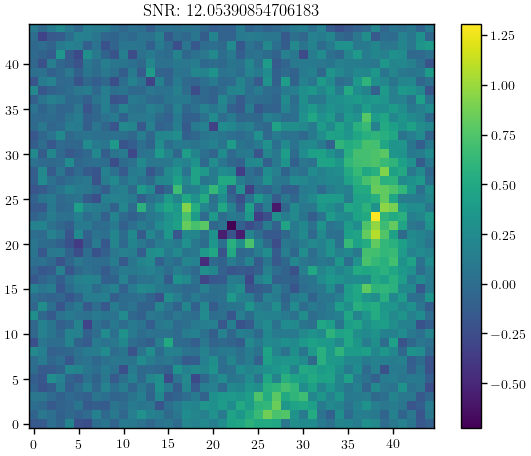

In [112]:
snr, total_image_with_noise = survey_sim.get_snr(sample_gglens, band)

plt.imshow(total_image_with_noise)
plt.title(f'SNR: {snr}')
plt.colorbar()
plt.show()

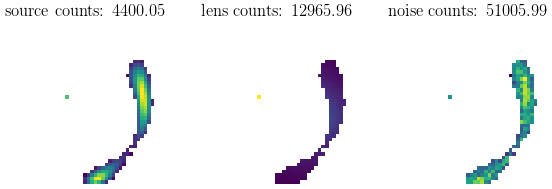

In [113]:
# mask source
masked_source = np.ma.masked_where(snr_array <= 1, source)
source_counts = masked_source.compressed().sum()

# mask lens
masked_lens = np.ma.masked_where(snr_array <= 1, lens)
lens_counts = masked_lens.compressed().sum()

# mask noise
masked_noise = np.ma.masked_where(snr_array <= 1, noise)
noise_counts = masked_noise.compressed().sum()

f, ax = plt.subplots(1, 3)
ax[0].imshow(masked_source)
ax[0].set_title(f'source counts: {source_counts:.2f}')
ax[0].axis('off')
ax[1].imshow(masked_lens)
ax[1].set_title(f'lens counts: {lens_counts:.2f}')
ax[1].axis('off')
ax[2].imshow(masked_noise)
ax[2].set_title(f'noise counts: {noise_counts:.2f}')
ax[2].axis('off')
plt.show()

In [114]:
np.set_printoptions(threshold=sys.maxsize)
print(masked_source.mask)

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True False False
  False False False False False  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True False False
  False False False False False False False  True  True  True  True  True
   True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True False False
  False False False False False False False  True  True  True  True  True
   True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
  False False F

In [116]:
regions = []
already_checked = set()

for i, j in np.transpose(np.nonzero(masked_source)):
    region = set()

    if (i, j) in already_checked:
        continue
    
    # check left neighbor
    if j != 0 and not masked_source.mask[i, j - 1]:
        region.add((i, j - 1))
    else:
        already_checked.add((i, j - 1))
    # check right neighbor
    if j != masked_source.shape[0]:
        region.add((i, j + 1))
    else:
        already_checked.add((i, j + 1))
    # check bottom neighbor
    if i != 0 and not masked_source.mask[i - 1, j]:
        region.add((i - 1, j))
    else:
        already_checked.add((i - 1, j))
    # check top neighbor
    if i != masked_source.shape[1]:
        region.add((i + 1, j))
    else:
        already_checked.add((i + 1, j))

    # TODO should move on to one of the neighbors instead of the next nonzero element, so that I can stay within one region and define it before moving on to the next region. something needs to prevent me from defining a region prematurely

    # if all neighbors have already been checked, append region and go on to defining next region
    regions.append(region)

In [117]:
print(len(regions))

163
